# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import Shrec17DeepSphere as shrecDataset
from SHREC17.load_shrec import fix_dataset

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
download = False
train_dataset = shrecDataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


31364it [00:48, 644.32it/s]


In [8]:
val_dataset = shrecDataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

5133it [00:08, 618.48it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

Number of elements / class


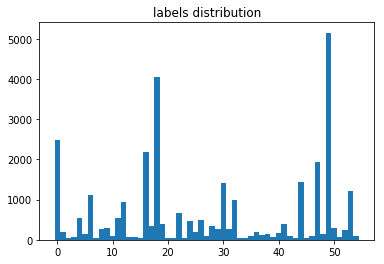

In [9]:
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

In [10]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
#ids = train_dataset.retrieve_ids()
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364 
first id: 034636


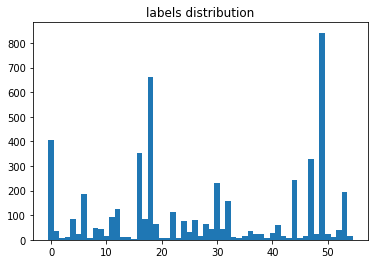

In [11]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [12]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
im1_norm = x_train[0,:,1]
im0003_norm = train_dataset.data[0,:,1]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(x_train[:,:,0])
cmax = np.max(x_train[:,:,0])
cmin_norm = np.min(x_train[:,:,1])
cmax_norm = np.max(x_train[:,:,1])

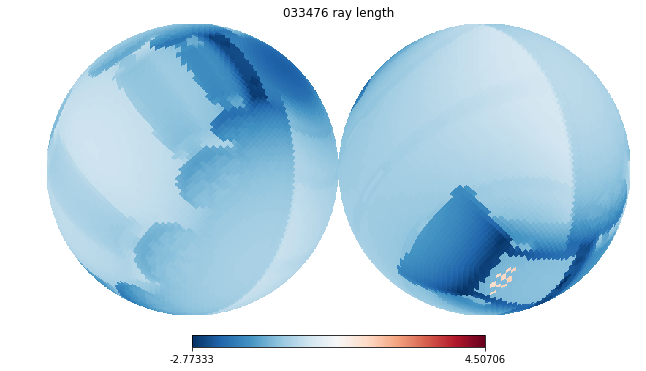

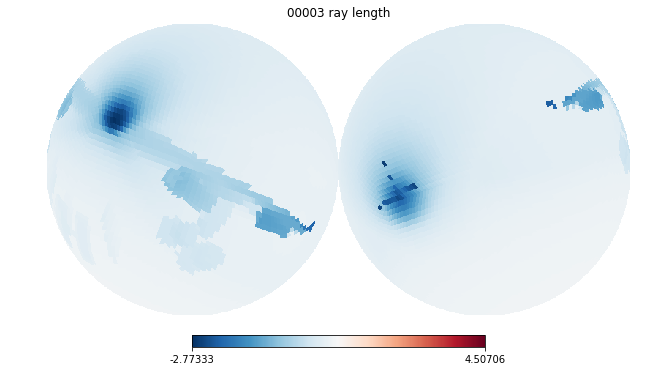

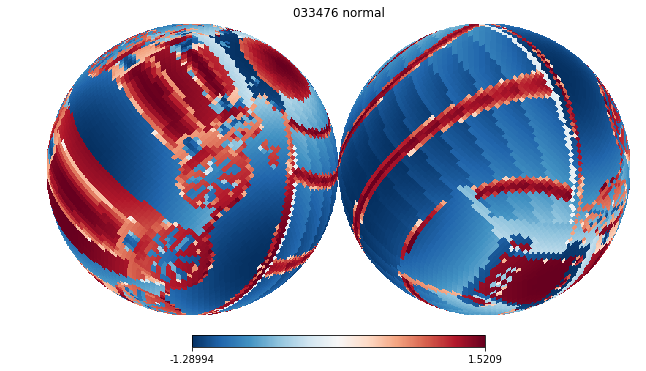

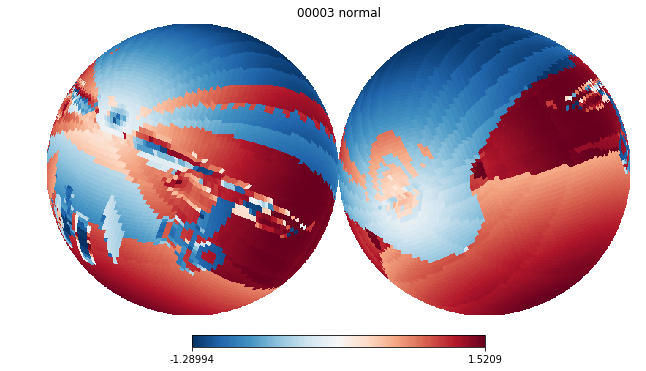

In [13]:
hp.orthview(im1, title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
hp.orthview(im0003, rot=(90,90,290), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
hp.orthview(im1_norm, title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin_norm, max=cmax_norm)
hp.orthview(im0003_norm, rot=(90,90,290), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin_norm, max=cmax_norm)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [12]:
#training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [13]:
EXP_NAME = 'shrec17_Cohen_simple_reg_5K_more_{}sides_{}noise{}'.format(Nside, sigma_noise, ename)
#EXP_NAME = 'shrec17_Cohen_simple_reg_2_{}sides_{}noise{}'.format(Nside, sigma_noise, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"
#EXP_NAME = 'plop'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [14]:
params = hyperparameters.get_params_shrec17(training.N, EXP_NAME, Nside, train_dataset.nclass, architecture=experiment_type)
model = models.deepsphere(**params)

#sides: [32, 8, 4]
#pixels: [12288, 768, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 115,620,249,600
Learning rate will start at 4.0e-02 and finish at 0.0e+00.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 5 = 3000
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 5 = 50000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [18]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
# backup = params.copy()

# params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

# shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
# shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

# model = models.deepsphere(**params)
# _, loss_validation, _, _ = model.fit(training, validation)

# params.update(backup)

# plt.semilogx(learning_rate, loss_validation, '.-')

## 2.2 Train Network

In [19]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 58,700


In [ ]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation)

step 1470 / 294037 (epoch 1.50 / 300):
  learning_rate = 2.11e-03, training loss = 1.17e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 72.80 (3737 / 5133), f1 (weighted): 70.55, loss: 1.26e+00
  CPU time: 110s, wall time: 192s
step 2940 / 294037 (epoch 3.00 / 300):
  learning_rate = 1.12e-04, training loss = 1.13e+00
  validation accuracy: 74.75 (3837 / 5133), f1 (weighted): 72.45, loss: 1.13e+00
  CPU time: 198s, wall time: 362s
step 4410 / 294037 (epoch 4.50 / 300):
  learning_rate = 5.89e-06, training loss = 1.11e+00
  validation accuracy: 75.02 (3851 / 5133), f1 (weighted): 72.80, loss: 1.12e+00
  CPU time: 287s, wall time: 533s
step 5880 / 294037 (epoch 6.00 / 300):
  learning_rate = 3.11e-07, training loss = 1.38e+00
  validation accuracy: 74.71 (3835 / 5133), f1 (weighted): 72.42, loss: 1.13e+00
  CPU time: 385s, wall time: 711s
step 7350 / 294037 (epoch 7.50 / 300):
  learning_rate = 1.64e-08, training loss = 8.89e-01
  validation accuracy: 75.16 (3858 / 5133), f1 (weighted): 73.01, loss: 1.12e+00
  CPU time: 476s, wall time: 885s
step 8820 / 294037 (epoch 9.00 / 300):
  learning_rate = 

  validation accuracy: 75.06 (3853 / 5133), f1 (weighted): 72.94, loss: 1.12e+00
  CPU time: 3545s, wall time: 6847s
step 60270 / 294037 (epoch 61.49 / 300):
  learning_rate = 0.00e+00, training loss = 9.74e-01
  validation accuracy: 75.49 (3875 / 5133), f1 (weighted): 73.35, loss: 1.12e+00
  CPU time: 3634s, wall time: 7018s
step 61740 / 294037 (epoch 62.99 / 300):
  learning_rate = 0.00e+00, training loss = 6.14e-01
  validation accuracy: 75.16 (3858 / 5133), f1 (weighted): 73.02, loss: 1.12e+00
  CPU time: 3721s, wall time: 7187s
step 63210 / 294037 (epoch 64.49 / 300):
  learning_rate = 0.00e+00, training loss = 9.59e-01
  validation accuracy: 75.45 (3873 / 5133), f1 (weighted): 73.31, loss: 1.12e+00
  CPU time: 3810s, wall time: 7357s
step 64680 / 294037 (epoch 65.99 / 300):
  learning_rate = 0.00e+00, training loss = 8.16e-01
  validation accuracy: 75.14 (3857 / 5133), f1 (weighted): 72.98, loss: 1.12e+00
  CPU time: 3897s, wall time: 7527s
step 66150 / 294037 (epoch 67.49 / 300)

  validation accuracy: 75.36 (3868 / 5133), f1 (weighted): 73.23, loss: 1.12e+00
  CPU time: 7206s, wall time: 14548s
step 117600 / 294037 (epoch 119.98 / 300):
  learning_rate = 0.00e+00, training loss = 9.03e-01
  validation accuracy: 74.95 (3847 / 5133), f1 (weighted): 72.74, loss: 1.12e+00
  CPU time: 7305s, wall time: 14782s
step 119070 / 294037 (epoch 121.48 / 300):
  learning_rate = 0.00e+00, training loss = 1.10e+00
  validation accuracy: 75.24 (3862 / 5133), f1 (weighted): 73.08, loss: 1.12e+00
  CPU time: 7404s, wall time: 15018s
step 120540 / 294037 (epoch 122.98 / 300):
  learning_rate = 0.00e+00, training loss = 8.62e-01
  validation accuracy: 74.89 (3844 / 5133), f1 (weighted): 72.63, loss: 1.13e+00
  CPU time: 7505s, wall time: 15256s
step 122010 / 294037 (epoch 124.48 / 300):
  learning_rate = 0.00e+00, training loss = 1.01e+00
  validation accuracy: 75.28 (3864 / 5133), f1 (weighted): 73.14, loss: 1.12e+00
  CPU time: 7606s, wall time: 15490s
step 123480 / 294037 (epoc

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [15]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN/model-149940


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 75.36 (3868 / 5133), f1 (weighted): 73.17, loss: 1.12e+00\nCPU time: 10s, wall time: 9s',
 75.3555425676992,
 73.1670703046484,
 1.1233850371737752)

In [16]:
probabilities = model.probs(x_val, nclass)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN/model-149940


In [ ]:
#predictions = predictions.astype(np.int)

In [18]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_5K_more/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_5K_more/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i] and i != j]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

## test network

In [19]:
test_dataset = shrecDataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:16, 623.94it/s]


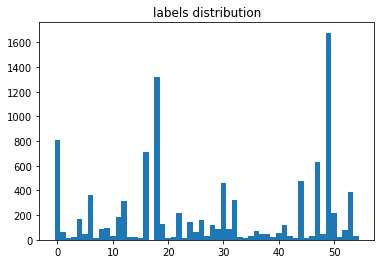

In [20]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [21]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN/model-149940


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 70.12 (7198 / 10265), f1 (weighted): 68.36, loss: 1.28e+00\nCPU time: 17s, wall time: 15s',
 70.12177301509985,
 68.35509417131253,
 1.2799943467784496)

In [ ]:
#predictions = model.predict(x_test)

In [22]:
probabilities = model.probs(x_test, nclass)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_more_32sides_0noise_CNN/model-149940


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [26]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_5K_more/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_5K_more/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [24]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

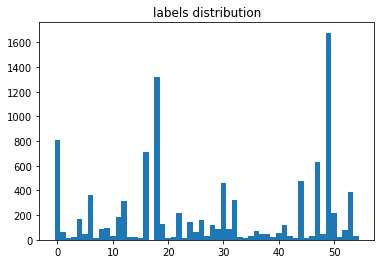

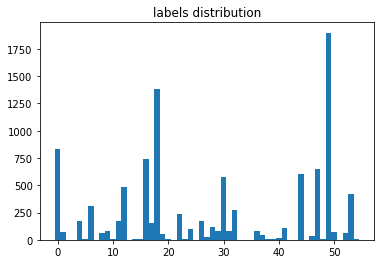

In [25]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)